In [337]:
import numpy as np
import quimb.tensor as qtn

import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

In [338]:
num_sites = 4
chi = 5

psi = qtn.MPS_rand_state(num_sites, chi, dtype=np.complex128, tags = ['PSI'])
print(psi.norm())
psi

0.9999999999999999


MatrixProductState(tensors=4, indices=7, L=4, max_bond=5)

## MMD computation with tensor network formalism

The Maximum Mean Discrepancy (MMD) is a distance measure between two probability distributions based on the expectation values of a positive semi-definite kernel function $ K(x, y) $. In our context, it is used to compare the distribution $ q_\theta(x) $, generated by a quantum model, with a target distribution $ p(x) $ obtained from classical data. The data samples $ y $ are bitstrings, i.e., elements of the computational basis.

$$
\begin{aligned}
\operatorname{mmd}(\theta)=\; & \sum_{x \in \Omega} \sum_{y \in \Omega} q_{\theta}(x) K(x, y) q_{\theta}(y)
+ \sum_{x \in T} \sum_{y \in T} p(x) p(y) K(x, y)
- 2 \sum_{x \in \Omega} \sum_{y \in T} q_\theta(x) K(x, y) p(y)
\end{aligned}
$$

using the Born rule $ q_\theta(x) = |\braket{x | \psi}|^2 $.

$$
\begin{align*}
\min_{\theta} \left[ \operatorname{mmd}(\theta)\right] =
\min \bigg[ 
&\sum_{x, y \in \Omega} \braket{\psi | x} \braket{x | \psi} \, K(x, y) \braket{\psi | y} \braket{y | \psi}
- 2 \sum_{x \in \Omega} \sum_{y \in T} \braket{\psi | x} \braket{x | \psi} K(x, y) p(y) 
\bigg] =
\end{align*}
$$



We can manually contruct the TN that represents the sampling probabilities of the state $\ket{\psi}$. For example, for a single biststring $b = b_1\ldots b_n$, the probability of sampling it is given by

$$p(b) = |\langle\psi|\bm{b}\rangle|^2 = \langle\psi|b\rangle \langle b|\psi\rangle = \langle\psi|\Pi_{b}|\psi\rangle$$

where in the last equation we defined the projector $\Pi_b = |b\rangle\langle b|$ corresponding to bitstring $b$. Now, focus on a single qubit and imagine we put together in a list the projectors on state $\ket{0}$ and $\ket{1}$, thus obtaining

$$\Pi = [\Pi_0, \Pi_1], \quad \Pi_0 = |0\rangle\langle0|, \Pi_1 = |1\rangle\langle1|$$

This object $\Pi$ is a tensor of dimensions (2, 2, 2), and it is essentially a representation of the POVM corresponding to measuring in the computational basis $Z$. One can then construct a TN that encodes the sampling probabilities from state $\ket{\psi}$ by using the formula above 

$$p(b_1b_2\ldots b_n) = \langle\psi|\Pi_{b_1} \otimes \Pi_{b_2} \ldots \otimes \Pi_{b_n}|\psi\rangle$$

where each of the local $\Pi_b$ is the (2,2,2) tensors introduced above. Imporantly, this is a tensor networks where the open legs are the outcomes one $b_i$.
For a single-qubit space, measuring only in $Z$ basis, this corresponds to 
$$
\left[
\begin{array}{cc|cc}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{array}
\right]
$$

For each node of the tensor network. We can create the single node and put them together in an MPO

In [339]:
# Projector |0X0|
p0 = np.array([[1,0],[0,0]]) 
# Projector |1X1|
p1 = np.array([[0,0],[0,1]])
# POVM with elements {|0X0|, |1X1|}
comp_basis_povm = np.array([p0, p1])

# Create MPO representation of the POVM.
# Indices o{} are used to label the possible outcomes (in this case 0 and 1 for each qubit)
tensors = []
for i in range(num_sites):
    t = qtn.Tensor(comp_basis_povm,
                   inds=(f'o{i}', f'k{i}', f'b{i}'), 
                   tags = [f'I{i}', 'POVM'])
    tensors.append(t)

povm_tn = qtn.TensorNetwork(tensors)
povm_tn

TensorNetwork(tensors=4, indices=12)

The expression $ \, p(b_1b_2\ldots b_n) = \langle\psi|\Pi_{b_1} \otimes \Pi_{b_2} \ldots \otimes \Pi_{b_n}|\psi\rangle \,$
can be built as:

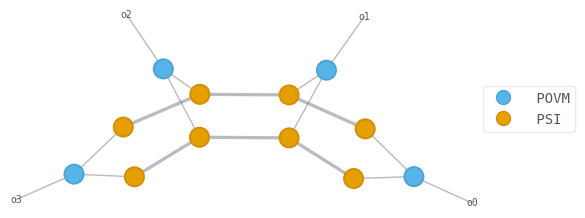

In [340]:
probs_tn = qtn.TensorNetwork([psi.H,
                              povm_tn, 
                              psi.reindex_sites('b{}')])

probs_tn.draw(color=['POVM', 'PSI'], show_tags=False)

The expression above become:

$$
\begin{align*}
= \min \left[
\sum_{x, y} \braket{\psi | \Pi | \psi} K(x, y) \braket{\psi | \Pi | \psi}
- 2 \sum_{x} \sum_{y} \braket{\psi | \Pi | \psi} K(x, y) p(y)
\right]
\end{align*}
$$


The kernel matrix $ K $ is defined as

$$
K = 
\begin{pmatrix}
1 & e^{-\frac{1}{2\sigma^2}} \\
e^{-\frac{1}{2\sigma^2}} & 1
\end{pmatrix}
$$

which encodes similarity between bitstrings using a Gaussian function. This matrix acts on the output space indexed by $ x $ and $ y $, and can be realized as a kernel MPO:

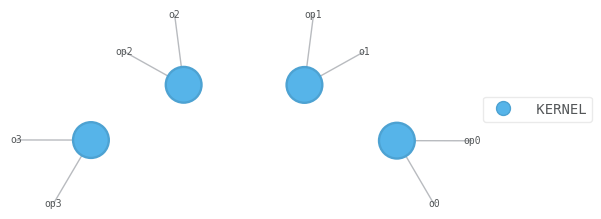

100.0


In [341]:
sigma = 0.5
fact = 1/(2*sigma**2)
kernel_mat = np.array([[1, fact],[fact, 1]])

# Kernel MPO
kernel_mpo = qtn.MPO_product_operator([kernel_mat]*num_sites,
                                      upper_ind_id = 'o{}', 
                                      lower_ind_id = 'op{}', # op stands for o prime, o'
                                      tags = ['KERNEL'])



kernel_mpo.draw(color=['KERNEL'],show_tags=False)
print(kernel_mpo.norm())

In full tensor index notation, the MMD becomes:

$$
\begin{aligned}
= \psi_b \, \Pi_k^{b, o} \, \psi^k \, K_{o}^{o'} \, \psi_b \, \Pi_k^{b, o'} \, \psi^k 
- 2\,\sum_B \left[ 
\psi^b \, \Pi_b^{ko} \, \psi_k \, K_{o}^{o'} \, B^o
\right]
\end{aligned}
$$

Here, $ \psi^k $ and $ \psi_b $ are the components of the quantum state $ \ket{\psi} $ and its dual $ \bra{\psi} $, respectively. Indices are placed according to the usual tensor convention: kets carry upper indices and bras lower indices. The operator $ \Pi $ is a tensor with indices $ \Pi_k^{b, o} $, encoding its action on both input and measurement bases. The sum over $ B $ denotes averaging over the target data bitstrings $ y $, with $ B^o $ representing the empirical frequency vector from data.

The first term can be built as:

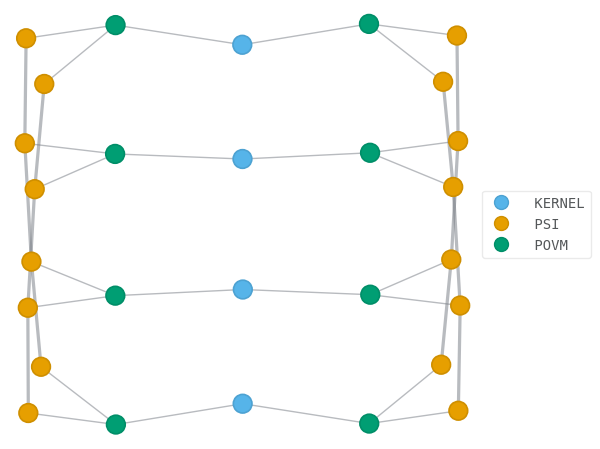

In [342]:
reindex_map = {f'o{i}': f'op{i}' for i in range(num_sites)}
overlap_tn = qtn.TensorNetwork([probs_tn, 
                                kernel_mpo,
                                probs_tn.reindex(reindex_map)])
overlap_tn.draw(color=['KERNEL', 'PSI', 'POVM'], show_tags=False)

The second term needs the MPS representation of data. We are going to build a "computational MPS" for each bitstring in the dataset, which can be thought as the eigenstate that gives every time we sample the original bitstring. To compute efficiently the sum over the all possible bitstrings, we can group all the computational MPS in an hyperindexed tensor network, quimb will then sum over the hyperindex efficently.

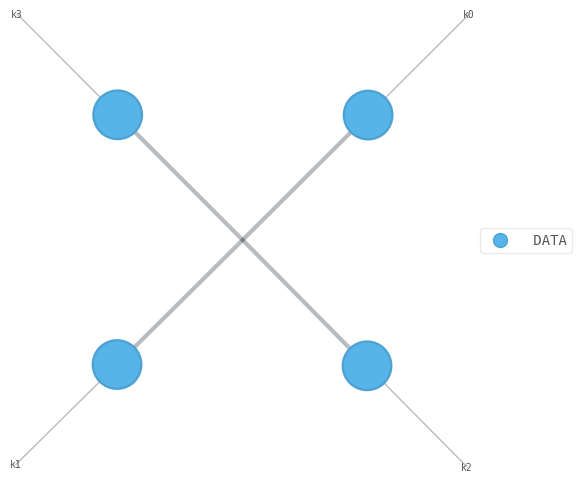

In [343]:
from src.dataset_utils import bars_and_stripes, hypertn_from_data

bas = bars_and_stripes(int(np.sqrt(num_sites)))
htn_data = hypertn_from_data(bas)
htn_data.draw(color=['DATA'], show_tags=False)

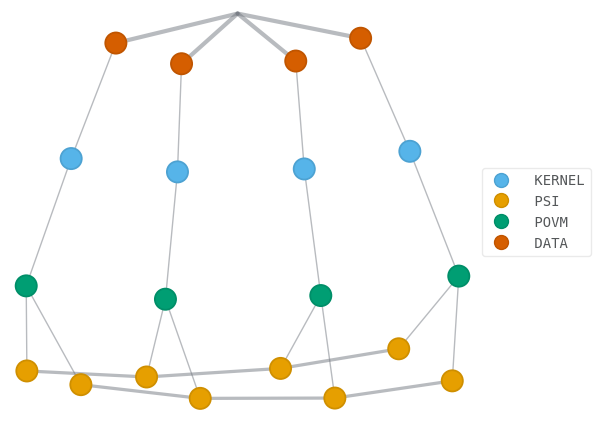

In [344]:
reindex_map = {f'k{i}': f'op{i}' for i in range(num_sites)}
overlap_data_tn = qtn.TensorNetwork([probs_tn, 
                                kernel_mpo,
                                htn_data.reindex(reindex_map) ])
overlap_data_tn.draw(color=['KERNEL', 'PSI', 'POVM', 'DATA'], show_tags=False)

In [345]:
overlap_data_tn.contract(output_inds=[], optimize='auto-hq')

41.52097469679364

We can build a single loss function to be minimized:

In [346]:
def mmd_loss(psi, povm_tn, kernel_mpo, htn_data):
    
    probs_tn = qtn.TensorNetwork([psi.H,
                              povm_tn, 
                              psi.reindex_sites('b{}')])
    
    reindex_map = {f'o{i}': f'op{i}' for i in range(num_sites)}
    model_tn = qtn.TensorNetwork([probs_tn, 
                                    kernel_mpo,
                                    probs_tn.reindex(reindex_map)])
    
    reindex_map_op = {f'k{i}': f'op{i}' for i in range(num_sites)}
    overlap_data_tn = qtn.TensorNetwork([probs_tn, 
                                    kernel_mpo,
                                    htn_data.reindex(reindex_map) ])
    
    reindex_map_o = {f'k{i}': f'o{i}' for i in range(num_sites)}
    data_tn = qtn.TensorNetwork([htn_data.reindex(reindex_map_o), 
                                    kernel_mpo,
                                    htn_data.reindex(reindex_map_op)])
    
    return model_tn.contract(output_inds=[], optimize='auto-hq') - 2*overlap_data_tn.contract(output_inds=[], optimize='auto-hq') + data_tn.contract(output_inds=[], optimize='auto-hq')

In [347]:
# normalize povm_tn
#povm_tn = povm_tn / povm_tn.norm()

# normalize kernel
kernel_mpo = kernel_mpo / kernel_mpo.norm()

# normalize htn_data
#htn_data = htn_data / htn_data.norm()

In [348]:
print(psi.norm())
print(povm_tn.norm())
print(kernel_mpo.norm())
print(htn_data.norm())

0.9999999999999999
4.0
1.0
3.4641016151377544


In [349]:
mmd_loss(psi, povm_tn, kernel_mpo, htn_data)

2.748224115889534

## KLD computation with tensor network formalism

$$
D_{KL}(P \| Q) = \sum_x P(x) \log \frac{P(x)}{Q_\theta(x)},
$$
where $P(x)$ is the target distribution, and $Q_\theta(x)$ is the model's distribution parameterized by $\theta$.
$$
= \sum_x P(x) \log P(x) - \sum_x P(x) \log Q_\theta(x).
$$
The only meaningful term for gradient over $\theta$ calculation is the second one, the negative-log-likelyhood. 

In [172]:
def nnl_loss(psi, htn_data):
    """
    Calculate the KL divergence between the MPS and the dataset.
    """
    loss = (psi | htn_data).contract(output_inds = ['hyper'], 
                                     optimize = 'auto-hq').data
    
    return -1. * jnp.mean(jnp.log(jnp.abs(loss) ** 2))